### imports

In [ ]:
import time
from PIL import Image
from IPython.core.display import display, HTML, clear_output
import threading

def show_image(image_path):
    max_i_height =600
    img = Image.open(image_path)

    # Check if the image height exceeds the max_i height
    if img.height > max_i_height:
        # Calculate the new width to maintain the aspect ratio
        new_width = int((max_i_height / img.height) * img.width)
        # Resize the image
        img = img.resize((new_width, max_i_height))
    
    # Show the image
    img.show()

def display_dashboard():
    time.sleep(5)
    def disp():
        display(HTML('<iframe src="http://127.0.0.1:4200/flow-runs" width="1400" height="700"></iframe>'))
    threading.Thread(target=disp).start()


def display_blocks():
    def disp():
        display(HTML('<iframe src="http://127.0.0.1:4200/blocks/catalog" width="1400" height="700"></iframe>'))
    threading.Thread(target=disp).start()

def display_queue():
    def disp():
            display(HTML('<iframe src="http://127.0.0.1:4200/work-pools/work-pool/default-agent-pool/queue/q-mediahaven" width="1400" height="700"></iframe>'))
    threading.Thread(target=disp).start()

```
prefect server start
```

# Prefect Intro

In [ ]:
show_image("0.0_Prefect_Technologies_Logo.jpg")

## Prefect according to Prefect

In [ ]:
show_image("0.1_Prefect.png")

In [ ]:
show_image("0.2_Pic-3-1.png")


In [ ]:
show_image("the-hitchhiker-s-guide-to-the-galaxy-the-illustrated-edition.jpg")

## From code...

In [ ]:
import time

def log(i):
    time.sleep(1)
    print(i)
    
def sub():
    log(f"Task in sub.")

def main(max_i: int):
    i = 0
    sub()
    while i < max_i:
        i += 1
        log(i)


if __name__ == "__main__":
    main(5)


## ... to flow

### Flow

`@flow`-decorator

- Most central Prefect object
- Python function
- Workflow logic as-code
- Subflow

### Task

`@task`-decorator

- Python function
- Function that represents a unit of work

### Logging

`get_run_logger()` specific for each task and flow

In [ ]:
import time
from prefect import flow, task, get_run_logger

@task() # task
def log(i):
    time.sleep(3)
    logger = get_run_logger()
    logger.info(i) # logging in task
    
@flow(name="test-subflow")
def sub_flow():
    logger = get_run_logger()
    logger.info("sub flow started")
    log("Task inside subflow")

@flow(name="test-flow") # main flow
def main_flow(max_i: int):
    logger = get_run_logger()
    logger.info("flow started") # logging in flow
    i = 0
    sub_flow() # sub flow
    while i < max_i:
        log(i)
        i += 1
display_dashboard()
if __name__ == "__main__":
    main_flow(5)

### With .submit()

In [ ]:

import time
from prefect import flow, task, get_run_logger

@task()
def log(i):
    time.sleep(5)
    logger = get_run_logger()
    logger.info(i) # logging
    
@flow(name="test-subflow")
def sub_flow():
    log("Task inside subflow")

@flow(name="test-flow")
def main_flow(max_i: int):
    i = 0
    sub_flow() # sub flow
    while i < max_i:
        i += 1
        log.submit(i) # Submit to runnner

display_dashboard()
if __name__ == "__main__":
    main_flow(5)

### With .map()

In [ ]:
import time
from prefect import flow, task, get_run_logger

@task()
def log(i):
    time.sleep(5)
    logger = get_run_logger()
    logger.info(i)
    
@flow(name="test-subflow")
def sub_flow():
    log("Task inside subflow")

@flow(name="test-flow")
def main_flow(max_i: int):
    sub_flow() # sub flow
    array = list(range(0, max_i + 1))
    log.map(array) # Map and submit
    
display_dashboard()
if __name__ == "__main__":
    main_flow(5)

## Task dependency

Task dependency is inferred automatically via inputs

In [ ]:
from prefect import flow, task, get_run_logger

import time
from prefect.task_runners import ConcurrentTaskRunner, SequentialTaskRunner


@task()
def double(i):
    return i*2

@task()
def log(i):
    time.sleep(5)
    logger = get_run_logger()
    logger.info(i)
    
@flow(name="test-subflow")
def sub_flow():
    log("Task inside subflow")

@flow(name="test-flow")
def main_flow(max_i: int):
    i = 0
    sub_flow()
    while i < max_i:
        i += 1
        double_i = double.submit(i)
        log.submit(double_i) # Task dependency
        
display_dashboard()
if __name__ == "__main__":
    main_flow(5)

Or stated explicitly via `wait_for`

In [ ]:
from prefect import flow, task, get_run_logger

import time

@task()
def blocking_task():
    time.sleep(5)
    logger = get_run_logger()
    logger.info("Wait for me!")

@task()
def double(i):
    return i*2

@task()
def log(i):
    time.sleep(5)
    logger = get_run_logger()
    logger.info(i)
    
@flow(name="test-subflow")
def sub_flow():
    log("Task inside subflow")

@flow(name="test-flow")
def main_flow(max_i: int):
    i = 0
    sub_flow()
    while i < max_i:
        i += 1
        double_i = double.submit(i)
        result_wait = blocking_task.submit()
        log.submit(double_i, wait_for=result_wait) # Task dependency without need for value

display_dashboard()
if __name__ == "__main__":
    main_flow(10)

## Errors & retries

Error in task -> Error in flow. Upstream task are not run, parallel tasks are!

In [ ]:
from prefect import flow, task, get_run_logger

import time


@task()
def blocking_task():
    time.sleep(5)
    logger = get_run_logger()
    raise ValueError("Error occured") # Throws an error

@task()
def double(i):
    return i*2

@task()
def log(i):
    time.sleep(5)
    logger = get_run_logger()
    logger.info(i)
    
@flow(name="test-subflow")
def sub_flow():
    log("Task inside subflow")

@flow(name="test-flow")
def main_flow(max_i: int):
    i = 0
    sub_flow()
    while i < max_i:
        i += 1
        double_i = double.submit(i) 
        result_wait = blocking_task.submit() 
        log.submit(double_i, wait_for=result_wait) 

display_dashboard()
if __name__ == "__main__":
    main_flow(5)

### With Retries & Exponential backoff

In [ ]:
from prefect import flow, task, get_run_logger

import time
import random


@task()
def blocking_task():
    time.sleep(5)
    logger = get_run_logger()

    chance = random.randint(1, 3) # 1/3 chance of error
    if chance == 1:
        raise ValueError("ValueError occurred!")

    logger.info("Wait for me!")

@task()
def double(i):
    return i*2

@task()
def log(i):
    time.sleep(5)
    logger = get_run_logger()
    logger.info(i)
    
@flow(name="test-subflow")
def sub_flow():
    log("Task inside subflow")

@flow(name="test-flow")
def main_flow(max_i: int):
    i = 0
    sub_flow()
    while i < max_i:
        i += 1
        double_i = double.submit(i) 
        result_wait = blocking_task.with_options(
            retries=6, # Retries when task fails
            retry_delay_seconds=[1, 2, 3, 4, 5, 6] # Exponential backoff
        ).submit() 
        log.submit(double_i, wait_for=result_wait) 

display_dashboard()
if __name__ == "__main__":
    main_flow(5)

## Server

[Link to dashboard (local)](http://127.0.0.1:4200/dashboard)

- Flows
- Flow Runs
- Deployments

## Deployments

- server-side representations of flows
- store when, where, and how a workflow should run

In [ ]:
%%bash
prefect deployment build main_flow.py:main_flow -n my-test-flow -q q-default --apply

In [ ]:
%%bash
prefect deployment build main_flow.py:main_flow -n my-test-flow-with-diff-param -q q-default --apply

### Parameters

- default values of flow parameters that this deployment will pass on each run

### Schedules

- tells the Prefect API how to create new flow runs for you automatically on a specified cadence

### Queues

## Agent 

(Replaced by workers after 3.0.0 upgrade)

- lightweight polling services that get scheduled work from a work pool
- Subscribes on a queue
- Runs your code 

In [ ]:
%%bash
prefect agent start -q 'q-default'

## Blocks

- store data
- store configuration and provide an interface for interacting with external systems
- e.g. download data from or upload data to an S3 bucket, query data from or write data to a database, ...

In [ ]:
display_blocks()

In [ ]:
from prefect import flow, task, get_run_logger
from prefect.blocks.system import String
import time
import random




@flow(name="test-flow")
def main_flow(
    block_name_mediahaven_query: str # Good practice: Block name as parameter
    ):
    logger = get_run_logger()
    mediahaven_query = String.load(block_name_mediahaven_query).value # Load block and get value
    logger.info(mediahaven_query)

display_dashboard()
if __name__ == "__main__":
    main_flow('query')

### Mediahaven client block

In [ ]:
from prefect import flow, task, get_run_logger
from prefect.blocks.system import String
import time
import random
from prefect_meemoo.mediahaven.credentials import MediahavenCredentials
from prefect_meemoo.mediahaven.tasks import search_records

    

@flow(name="test-flow")
def main_flow(
    max_i: int,
    block_name_mediahaven_query: str,
    mediahaven_credentials_block: str
    ):
    logger = get_run_logger()

    mediahaven_query = String.load(block_name_mediahaven_query).value # Load block and get value
    mediahaven_client = MediahavenCredentials.load(mediahaven_credentials_block).get_client() # Load block and call function on it to get client
    i = 0
    while i < max_i:
        i += 1
        results = search_records.with_options(tags=["mediahaven"]).submit(mediahaven_client, mediahaven_query, start_index=i, nr_of_results=1).result() # call task from library, add tag
        logger.info(results.page_result.Results[0].Descriptive.Description)

display_dashboard()
if __name__ == "__main__":
    main_flow(5, 'query', 'mediahaven-prd')

### Schedule with concurrency on queue

In [19]:
%%bash
prefect deployment build main_flow_mediahaven.py:main_flow -n my-mediahaven-test-flow -q q-mediahaven --apply

/home/lennert/.pyenv/versions/3.8.9/envs/prefect-env/lib/python3.8/site-packages/prefect/tasks.py:332: UserWarning: A task named 'Get organisation' and defined at '/home/lennert/.pyenv/versions/3.8.9/envs/prefect-env/lib/python3.8/site-packages/prefect_meemoo/mediahaven/tasks.py:50' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


Found flow 'test-flow'
Deployment YAML created at '/home/lennert/test/flows/main_flow-deployment.yaml'.
Deployment storage None does not have upload capabilities; no files uploaded.  
Pass --skip-upload to suppress this warning.
Deployment 'test-flow/my-mediahaven-test-flow' successfully created with id 
'ba09d68b-5fc1-4d6f-bdd2-04fbec0706f7'.

To execute flow runs from this deployment, start an agent that pulls work from 
the 'q-mediahaven' work queue:
$ prefect agent start -q 'q-mediahaven'


In [ ]:
display_queue()

## Prefect at meemoo

### prefect_meemoo python library

- Library with reusable tasks
- Blocks e.g. MediahavenCredentials

### prefect-flow's

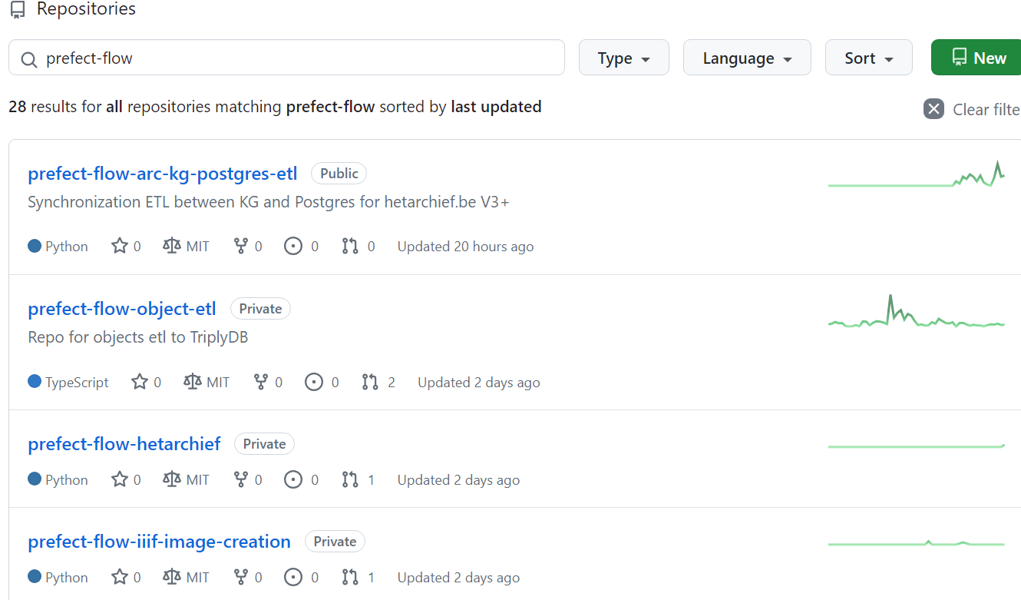

In [20]:
show_image("0.3_prefect_flows.png")

### Environments

- [INT Dashboard](http://do-int-prf-01.do.viaa.be:4200/dashboard)
- [QAS Dashboard](http://do-qas-prf-01.do.viaa.be:4200/dashboard)
- [PRD Dashboard](http://do-prd-prf-01.do.viaa.be:4200/dashboard)

Slack notifications in [#archief-alerts](https://viaa.slack.com/archives/C03EUPCHN4U)

### Deployment

- [Cookiecutter flow repo template](https://github.com/viaacode/meemoo-cookiecutter-prefect-flow)
- Jenkinspipeline with deployment via Docker images